# Descan + STEM Overfocus procedure

Suppose we have three overfocus datasets (shadow image), taken at three *known* camera lengths (e.g. calibrated with polycrystalline gold diffraction rings). This notebook walks through the process to determine both the descan error matrix of the microscope, as well as the scan-to-detector geometry and defocus of each dataset.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from scipy.optimize import curve_fit
import libertem.api as lt
from libertem.udf.sum import SumUDF
from libertem.udf.com import CoMUDF
from libertem.udf.masks import ApplyMasksUDF

In [2]:
import jaxgym.components as comp
from interactive import interactive_window

Here load three datasets with the three known camera lengths

In [3]:
ctx = lt.Context.make_with(cpus=8)  # no parallelisation, good for debugging
datasets = {
    0.5: ctx.load("npy", "./fourdstem_array_0.5.npy"),
    1.0: ctx.load("npy", "./fourdstem_array_1.0.npy"),
    1.5: ctx.load("npy", "./fourdstem_array_1.5.npy"),
}
datasets[1.5].shape

(103, 106, 96, 96)

Just for visualisation, we start with a sum image of all dataset frames, and the CoM shift magnitude relative to the frame centre for each scan position:

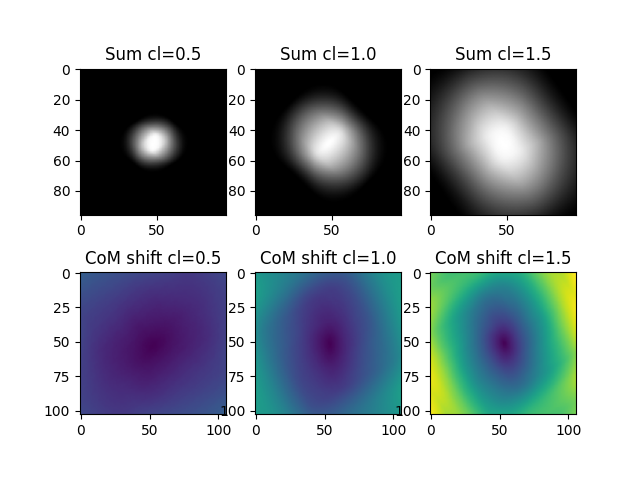

In [4]:
fig, axs = plt.subplots(2, 3)

com_r = {}
com_udf = CoMUDF.with_params()
for i, (cl, ds) in enumerate(datasets.items()):
    sum_res, com_res = ctx.run_udf(ds, [SumUDF(), com_udf])
    com_r[cl] = com_res
    axs[0, i].imshow(sum_res["intensity"].data, cmap="gray")
    axs[0, i].set_title(f"Sum cl={cl}")

vmax = max(r["magnitude"].data.max() for r in com_r.values())
for i, (cl, ds) in enumerate(datasets.items()):
    axs[1, i].imshow(com_r[cl]["magnitude"].data, vmin=0, vmax=vmax)
    axs[1, i].set_title(f"CoM shift cl={cl}")

We can see that there is mose descan error at longer camera lengths, meaning we have an error dependent on the slope of the rays leaving the descanner.

Now we have an estimate of the CoM shift for each dataset we can compute a point virtual detector image with and without descan compensation

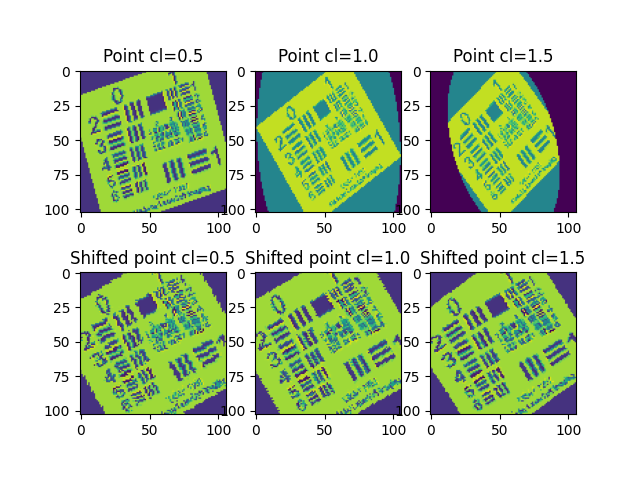

In [5]:
sy, sx = ds.shape.sig.to_tuple()
mask_px = sy // 2, sx // 2

def mask_factory():
    mask = np.zeros((sy, sx), dtype=np.float32)
    mask[mask_px] = 1.
    return mask

masks_udf = ApplyMasksUDF(
    [mask_factory],
    use_torch=False,
    use_sparse=False,
    mask_count=1,
)

fig, axs = plt.subplots(2, 3)

for i, (cl, ds) in enumerate(datasets.items()):
    
    masks_shifted_udf = ApplyMasksUDF(
        [mask_factory],
        use_torch=False,
        use_sparse=False,
        mask_count=1,
        shifts=ApplyMasksUDF.aux_data(
            np.round(com_r[cl]["raw_shifts"].data).astype(int),
            dtype=int,
            kind="nav",
            extra_shape=(2,),
        ),
    )
    sum_res, com_res = ctx.run_udf(ds, [masks_udf, masks_shifted_udf])

    axs[0, i].imshow(sum_res["intensity"].data)
    axs[0, i].set_title(f"Point cl={cl}")
    axs[1, i].imshow(com_res["intensity"].data)
    axs[1, i].set_title(f"Shifted point cl={cl}")

As we can see, the descan compensation approximately corrects for the distortion of the scan grid, making the point image square, and independent of camera length

We can now determine scan rotation, step and flip on one dataset, while ignoring the descan error

In [6]:
cl = 1.0
ds = datasets[cl]
# initial_guesses
model_parameters = {
    'semi_conv': 0.1,
    'defocus': 0.02, # Distance from the crossover to the sample
    'camera_length': cl, # Distance from the sample to the detector
    'scan_shape': ds.shape.nav, # YX!
    'det_shape': ds.shape.sig, # YX!
    'scan_step': (0.0001, 0.0001), # YX!
    'det_px_size': (0.004, 0.004), #YX!
    'scan_rotation': 30.,
    'descan_error': np.zeros((8,)),
    'flip_y': False,
}
interactive_window(ctx, ds, model_parameters)

BokehModel(combine_events=True, render_bundle={'docs_json': {'fafa09ac-4043-4a71-85e7-414f04ad427a': {'version…

We would have to determine the defocus of each dataset separately, unless we knew it was unchanged

In [7]:
flip_y = False
semiconv = 0.1
scan_rotation = 30
defocus = 0.02
scan_step = (0.0001, 0.0001)
det_px_size = (0.004, 0.004)
flip_y = False

With these parameters determined, we can then solve simultaneously on the three datasets to determine the descan error matrix

In [8]:
scan_coords = []
det_coords = []
b_vals = []
for camera_length, ds in datasets.items():
    crossover_z = jnp.zeros((1))
    ScanGrid = comp.ScanGrid(z=jnp.array([defocus]), scan_step=scan_step, scan_shape=ds.shape.nav.to_tuple(), scan_rotation=scan_rotation)
    scan_coords.append(ScanGrid.coords)
    Detector = comp.Detector(z=jnp.array(camera_length), det_shape=ds.shape.sig.to_tuple(), det_pixel_size=det_px_size, flip_y=flip_y)
    yx_px_det = com_r[camera_length]["raw_com"].data.reshape(-1, 2)
    det_coords.append(np.stack(Detector.pixels_to_metres(yx_px_det.T), axis=1))
    b_vals.append(camera_length - defocus)

bvals = np.concatenate(tuple(np.full((c.shape[0],), b) for b, c in zip(b_vals, scan_coords)))
scan_coords = np.concatenate(scan_coords, axis=0)
det_coords = np.concatenate(det_coords, axis=0)
bvals.shape

ERROR:2025-06-16 09:23:54,583:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/nobackup/mb265392/.pyenv/versions/temgym/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 135, in _version_check
    version = get_version()
              ^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:81: operation cusparseGetProperty(MAJOR_VERSION, &major) failed: The cuSPARSE library was not found.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/nobackup/mb265392/.pyenv/versions/temgym/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/nobackup/mb265392/.pyenv/versions/temgym/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 230, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  Fi

(32754,)

In [9]:
def descan_model(vars, Adx_dpos, Cdx_dslope, Ady_dpos, Cdy_dslope):
    xin, yin, B = vars
    return xin * (Adx_dpos + B * Cdx_dslope) + yin * (Ady_dpos + B * Cdy_dslope)


# Take only N random samples from the data
num_samples = 100
indices = np.random.choice(bvals.size, num_samples, replace=False)

popt_x, pcov_x = curve_fit(descan_model, (scan_coords[:, 0][indices], scan_coords[:, 1][indices], bvals[indices]), det_coords[:, 0][indices], p0=np.zeros(4))
Axx, Cxx, Axy, Cxy = popt_x

popt_y, pcov_y = curve_fit(descan_model, (scan_coords[:, 0][indices], scan_coords[:, 1][indices], bvals[indices]), det_coords[:, 1][indices], p0=np.zeros(4))
Ayx, Cyx, Ayy, Cyy = popt_y

In [10]:
print("\nFit ABCD Values (with 5-sigma error):")
print(f"Axx_dpos = {Axx:.2f} ± {5*np.sqrt(pcov_x[0,0]):.2e}")
print(f"Axy_dpos = {Axy:.2f} ± {5*np.sqrt(pcov_x[2,2]):.2e}")
print(f"Ayx_dpos = {Ayx:.2f} ± {5*np.sqrt(pcov_y[0,0]):.2e}")
print(f"Ayy_dpos = {Ayy:.2f} ± {5*np.sqrt(pcov_y[2,2]):.2e}")
print(f"Cxx_dslope = {Cxx:.2f} ± {5*np.sqrt(pcov_x[1,1]):.2e}")
print(f"Cxy_dslope = {Cxy:.2f} ± {5*np.sqrt(pcov_x[3,3]):.2e}")
print(f"Cyx_dslope = {Cyx:.2f} ± {5*np.sqrt(pcov_y[1,1]):.2e}")
print(f"Cyy_dslope = {Cyy:.2f} ± {5*np.sqrt(pcov_y[3,3]):.2e}")


Fit ABCD Values (with 5-sigma error):
Axx_dpos = 7.63 ± 1.22e+00
Axy_dpos = 11.33 ± 1.07e+00
Ayx_dpos = -13.32 ± 1.85e+00
Ayy_dpos = 5.09 ± 1.62e+00
Cxx_dslope = -20.16 ± 1.15e+00
Cxy_dslope = -11.29 ± 9.98e-01
Cyx_dslope = 19.22 ± 1.74e+00
Cyy_dslope = -15.82 ± 1.51e+00


In [11]:
cl = 1.0
ds = datasets[cl]
# initial_guesses
model_parameters = {
    'semi_conv': semiconv,
    'defocus': defocus, # Distance from the crossover to the sample
    'camera_length': cl, # Distance from the sample to the detector
    'scan_shape': ds.shape.nav, # YX!
    'det_shape': ds.shape.sig, # YX!
    'scan_step': scan_step, # YX!
    'det_px_size': det_px_size, #YX!
    'scan_rotation': scan_rotation,
    'descan_error': np.asarray([Axx - 1, Axy, Ayx, Ayy - 1, Cxx, Cxy, Cyx, Cyy]),
    'flip_y': flip_y,
}
interactive_window(ctx, ds, model_parameters)

BokehModel(combine_events=True, render_bundle={'docs_json': {'c3b3ac1c-2bd0-44a2-b7b8-10c8b9e33ab2': {'version…